# Applying BERT Multilingual Classifier to Predict Account Suspension 

Phase 2

Guidance from: https://github.com/kacossio/TeamPython/blob/master/Bert%20Multilingual%20Embedding.ipynb

## 1. Load Packages

In [244]:
########## Load Packages
import warnings
warnings.simplefilter("ignore")

import importlib
import pandas as pd
import numpy as np
import re
from io import StringIO
import itertools
import os 
import time
import datetime

from io import StringIO # python3; python2: BytesIO 
import boto3

import emoji
import random 
import math

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import math

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## 2. Set parameters

In [245]:
# Set Parameters 
########## Set Parameters

# Indicate how many rows to skip before columns
# Note: Python uses zero-based indexing, so skiprow=0 begins at the first row of file,
# while skiprow=1 begins at the second row.
skiprow=0

# Indicate name of column that contains text data for analysis
text_column = "text"

import_bucket = "data/s3_data/nort_downsampled_full_clean/"

embedding_bucket = "data/s3_data/embeddings/final_embeddings_textclass/"

results_bucket = 'data/s3_data/' # already created on S3

## 3. Load in Data

### Load in data from S3 - Original Data

In [246]:
#### Load in data from S3

# Import Train and Measure Balance
# Import Flattened Data
df_train = pd.read_csv(import_bucket + "downsamp_df_train_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')

df_train['suspended'] = pd.to_numeric(df_train['suspended'], errors='coerce')
df_train = df_train[df_train['suspended'].notna()]

# Import Test and Measure Balance

df_test = pd.read_csv(import_bucket + "downsamp_df_test_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')

df_test['suspended'] = pd.to_numeric(df_test['suspended'], errors='coerce')
df_test = df_test[df_test['suspended'].notna()]

# Import Validation and Measure Balance
# Import Flattened Data
df_valid = pd.read_csv(import_bucket + "downsamp_df_valid_full_cleaned_pe.csv", error_bad_lines=False, encoding='utf-8')

df_valid['suspended'] = pd.to_numeric(df_valid['suspended'], errors='coerce')
df_valid = df_valid[df_valid['suspended'].notna()]

In [247]:
df_train = df_train.drop_duplicates(subset=['id'])
df_valid = df_valid.drop_duplicates(subset=['id'])
df_test = df_test.drop_duplicates(subset=['id'])

### Import Full Dataframes with Embeddings 

Multilingual

In [248]:
bert_embeddings_df_train = pd.read_csv(embedding_bucket + "nort_multilingual_downsampled/results/ml_training_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_test = pd.read_csv(embedding_bucket + "nort_multilingual_downsampled/results/ml_test_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_valid = pd.read_csv(embedding_bucket + "nort_multilingual_downsampled/results/ml_valid_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')

In [249]:
bert_embeddings_df_train['id'] = bert_embeddings_df_train['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_train['id'] = bert_embeddings_df_train['id'].astype('float')
bert_embeddings_df_valid['id'] = bert_embeddings_df_valid['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_valid['id'] = bert_embeddings_df_valid['id'].astype('float')
bert_embeddings_df_test['id'] = bert_embeddings_df_test['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_test['id'] = bert_embeddings_df_test['id'].astype('float')

Labse

In [250]:
bert_embeddings_df_train_labse = pd.read_csv(embedding_bucket + "nort_labse_downsampled/results/labse_train_embeddings_df.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_test_labse = pd.read_csv(embedding_bucket + "nort_labse_downsampled/results/labse_test_embeddings_df_full.csv", error_bad_lines=False, encoding='utf-8')
bert_embeddings_df_valid_labse = pd.read_csv(embedding_bucket + "nort_labse_downsampled/results/labse_valid_embeddings_df.csv", error_bad_lines=False, encoding='utf-8')

In [251]:
bert_embeddings_df_train_labse['id'] = bert_embeddings_df_train_labse['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_train_labse['id'] = bert_embeddings_df_train_labse['id'].astype('float')
bert_embeddings_df_valid_labse['id'] = bert_embeddings_df_valid_labse['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_valid_labse['id'] = bert_embeddings_df_valid_labse['id'].astype('float')
bert_embeddings_df_test_labse['id'] = bert_embeddings_df_test_labse['id'].apply(lambda x: x.replace("'", ''))
bert_embeddings_df_test_labse['id'] = bert_embeddings_df_test_labse['id'].astype('float')

### Check Lengths 

In [252]:
print("full train:", len(df_train), "unique ids train:", len(df_train['id'].unique()), 
      "full valid:", len(df_valid), "unique ids valid:", len(df_valid['id'].unique()), 
      "full test:", len(df_test), "unique ids test:", len(df_test['id'].unique()))

full train: 15830 unique ids train: 15830 full valid: 7247 unique ids valid: 7247 full test: 20518 unique ids test: 20518


In [253]:
print("full train:", len(bert_embeddings_df_train), "unique ids train:", len(bert_embeddings_df_train['id'].unique()), 
      "full valid:", len(bert_embeddings_df_valid), "unique ids valid:", len(bert_embeddings_df_valid['id'].unique()), 
      "full test:", len(bert_embeddings_df_test), "unique ids test:", len(bert_embeddings_df_test['id'].unique()))

full train: 15830 unique ids train: 15830 full valid: 7247 unique ids valid: 7247 full test: 20518 unique ids test: 20518


In [254]:
print("full train:", len(bert_embeddings_df_train_labse), "unique ids train:", len(bert_embeddings_df_train_labse['id'].unique()), 
      "full valid:", len(bert_embeddings_df_valid_labse), "unique ids valid:", len(bert_embeddings_df_valid_labse['id'].unique()), 
      "full test:", len(bert_embeddings_df_test_labse), "unique ids test:", len(bert_embeddings_df_test_labse['id'].unique()))

full train: 15830 unique ids train: 15830 full valid: 7247 unique ids valid: 7247 full test: 20518 unique ids test: 20518


## 5. Base Models: Fully Connected Models (No Fine-Tuning)

In [255]:
import pandas as pd
import re
import numpy as np
from sklearn import preprocessing
import pickle
import pandas as pd
import pickle
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow import keras
import random as rn
from keras.models import Model,save_model, load_model, Sequential
from keras.layers import Flatten,AveragePooling1D,Dropout,Dense,Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras.backend as K
import IPython
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
from keras.utils import to_categorical
import pydot
import graphviz
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import kerastuner as kt
from kerastuner import HyperModel
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Get rid of perfect predictor vars 

In [256]:
bert_embeddings_df_train_fm = bert_embeddings_df_train.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_valid_fm = bert_embeddings_df_valid.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_test_fm = bert_embeddings_df_test.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                           "user.has_extended_profile_False", "user.protected_False", 
                                                           "user.verified_False", "user.geo_enabled_False",
                                                           "user.geo_enabled_True", "user.default_profile_True"], axis=1)

In [257]:
bert_embeddings_df_train_fm_labse = bert_embeddings_df_train_labse.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_valid_fm_labse = bert_embeddings_df_valid_labse.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                             "user.has_extended_profile_False", "user.protected_False", 
                                                             "user.verified_False", "user.geo_enabled_False",
                                                             "user.geo_enabled_True", "user.default_profile_True"], axis=1)
bert_embeddings_df_test_fm_labse = bert_embeddings_df_test_labse.drop(['id', "user.id", "user.created_at", "user.has_extended_profile_True", 
                                                           "user.has_extended_profile_False", "user.protected_False", 
                                                           "user.verified_False", "user.geo_enabled_False",
                                                           "user.geo_enabled_True", "user.default_profile_True"], axis=1)

### Prep Data to Convert to Tensor

In [258]:
pd.set_option('display.max_columns', None)
bert_embeddings_df_train.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_in,lang_is,lang_it,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_mr,lang_my,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387

In [259]:
#combined_features_train = bert_embeddings_df_train.drop(['suspended'], axis=1)
acct_features_train = bert_embeddings_df_train_fm.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_train_fm.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_train = bert_embeddings_df_train_fm.iloc[:, bert_embeddings_df_train_fm.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_train = bert_embeddings_df_train_fm['suspended']

#bert_embeddings_df_train.drop(['suspended'], axis=1).columns.get_loc(0)

#gets country label number
num_of_labels=labels_train.nunique()
num_of_labels

2

In [260]:
labels_train.unique()

array([1, 0])

#### Feature Selection

#### Option 1: Use Random Forest Feature Selection for Account Features 

I specify the random forest instance, indicating the number of trees. Then I use selectFromModel object from sklearn to automatically select the features.

To note, this is much faster than LASSO. 

In [261]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

Double check to ensure no missingness ahead of random forest feature selection 

In [262]:
#pd.set_option('display.max_rows', None)
acct_features_train.isna().sum()

created_at                             0
retweet_count                         67
favorite_count                        67
quoted_status_id                       0
user.favourites_count                  0
                                      ..
place.country_United Arab Emirates     0
place.country_United States            0
user.verified_False.1                  0
is_quote_status_False                  0
is_quote_status_True                   0
Length: 143, dtype: int64

In [263]:
start_time = time.time()

acct_features_train['since_last_tweet_mins'] = pd.to_numeric(acct_features_train['since_last_tweet_mins'], errors='coerce')
acct_features_train['user.followers_countdailychange'] = pd.to_numeric(acct_features_train['user.followers_countdailychange'], errors='coerce')
acct_features_train['user.friends_countdailychange'] = pd.to_numeric(acct_features_train['user.friends_countdailychange'], errors='coerce')

acct_features_train = acct_features_train.replace([np.inf, -np.inf], np.nan)

acct_features_train = acct_features_train.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.02051830291748047 seconds ---


In [264]:
#generate random seed
def random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   rn.seed(seed)

random_seeds(1234)

To see which features are important we can use get_support method on the fitted model. It will return an array of boolean values. True for the features whose importance is greater than the mean importance and False for the rest.

In [265]:
feat_labels = acct_features_train.columns

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

forest.fit(acct_features_train, labels_train)
importances = forest.feature_importances_ # probably even simpler than the code I had

indices = np.argsort(importances)[::-1]

In [266]:
for f in range(acct_features_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

 1) since_last_tweet_mins_max      0.117423
 2) avg_tweets_per_day             0.077952
 3) since_last_tweet_mins_mean     0.066933
 4) user.friends_countdailychange  0.061624
 5) user.followers_countdailychange 0.050286
 6) user.urls_per_tweet            0.049616
 7) no_urls_per_tweet              0.047355
 8) avg_tweets_per_hr              0.044603
 9) no_mentions_per_tweet          0.043101
10) no_hashtags_per_tweet          0.042789
11) user.statuses_count            0.039742
12) followers_per_followees        0.038981
13) user.favourites_count          0.037597
14) user.friends_count             0.034151
15) tweets_per_day                 0.028968
16) user.followers_count           0.027802
17) user.screen_name.length        0.024701
18) source_Twitter for Android     0.020407
19) user.screen_name.digit_length  0.018771
20) created_at                     0.017912
21) user.followers_rate            0.015815
22) user.has_location              0.012404
23) user_age                   

In [267]:
sel = SelectFromModel(forest, prefit=True)
selected_feat= acct_features_train.columns[(sel.get_support())]
len(selected_feat)

25

In [268]:
selected_feat

Index(['created_at', 'user.favourites_count', 'user.followers_count',
       'user.friends_count', 'user.statuses_count', 'user_age',
       'tweets_per_day', 'since_last_tweet_mins_max',
       'since_last_tweet_mins_mean', 'avg_tweets_per_hr', 'avg_tweets_per_day',
       'followers_per_followees', 'user.urls_per_tweet',
       'no_hashtags_per_tweet', 'no_mentions_per_tweet', 'no_urls_per_tweet',
       'user.followers_countdailychange', 'user.friends_countdailychange',
       'user.friend_rate', 'user.followers_rate', 'user.has_location',
       'user.screen_name.digit_length', 'user.screen_name.length',
       'source_Twitter Web App', 'source_Twitter for Android'],
      dtype='object')

In [269]:
scaler = StandardScaler()

acct_features_train = acct_features_train[selected_feat]

# Scale account features 
acct_features_train[acct_features_train.columns] = scaler.fit_transform(acct_features_train[acct_features_train.columns])

combined_features_train = pd.concat([acct_features_train, text_feature_train], axis=1)

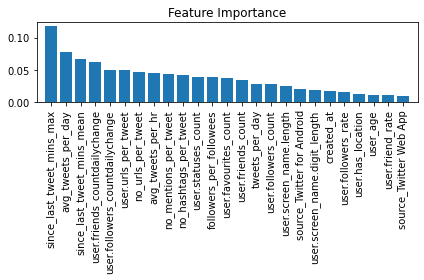

In [270]:
plt.title('Feature Importance')
plt.bar(range(acct_features_train.shape[1]), 
        importances[indices][0:len(selected_feat)],
        align='center')

plt.xticks(range(acct_features_train.shape[1]), 
           feat_labels[indices][0:len(selected_feat)], rotation=90)
plt.xlim([-1, acct_features_train.shape[1]])
plt.tight_layout()
plt.savefig(results_bucket + 'nort_feature importance_downsamp.png', dpi=300)
plt.show()

#### Resume after feature selection

Valid

In [35]:
#combined_features_valid = bert_embeddings_df_valid.drop(['suspended'], axis=1)
acct_features_valid = bert_embeddings_df_valid_fm.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_valid_fm.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_valid = bert_embeddings_df_valid_fm.iloc[:, bert_embeddings_df_valid_fm.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_valid = bert_embeddings_df_valid_fm['suspended']

#gets country label number
num_of_labels_valid=labels_valid.nunique()
num_of_labels_valid

2

In [36]:
acct_features_valid = acct_features_valid[selected_feat]

### Interpolate Validation and Test to Match up with Train

In [37]:
#pd.set_option('display.max_rows', None)
acct_features_valid.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            0
since_last_tweet_mins_mean           0
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees              0
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange     71
user.friends_countdailychange       71
user.friend_rate                     2
user.followers_rate                148
user.has_location                    0
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter Web App               0
source_Twitter for Android           0
dtype: int64

In [38]:
start_time = time.time()

acct_features_valid['user.followers_countdailychange'] = pd.to_numeric(acct_features_valid['user.followers_countdailychange'], errors='coerce')
acct_features_valid['user.friends_countdailychange'] = pd.to_numeric(acct_features_valid['user.friends_countdailychange'], errors='coerce')

acct_features_valid = acct_features_valid.replace([np.inf, -np.inf], np.nan)

acct_features_valid = acct_features_valid.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.006134033203125 seconds ---


In [39]:
len(acct_features_valid.columns)

25

Scale valid features

In [40]:
# Scale account features 
acct_features_valid[acct_features_valid.columns] = scaler.fit_transform(acct_features_valid[acct_features_valid.columns])

In [41]:
combined_features_valid = pd.concat([acct_features_valid, text_feature_valid], axis=1)

Test

In [42]:
acct_features_test = bert_embeddings_df_test_fm.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_test_fm.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_test = bert_embeddings_df_test_fm.iloc[:, bert_embeddings_df_test_fm.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_test = bert_embeddings_df_test_fm['suspended']

#gets country label number
num_of_labels_test=labels_test.nunique()
num_of_labels_test

2

In [43]:
acct_features_test = acct_features_test[selected_feat]

In [44]:
#pd.set_option('display.max_rows', None)
acct_features_test.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            2
since_last_tweet_mins_mean           2
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees              5
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    259
user.friends_countdailychange      259
user.friend_rate                     2
user.followers_rate                359
user.has_location                    0
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter Web App               0
source_Twitter for Android           0
dtype: int64

In [45]:
start_time = time.time()

acct_features_test['user.followers_countdailychange'] = pd.to_numeric(acct_features_test['user.followers_countdailychange'], errors='coerce')
acct_features_test['user.friends_countdailychange'] = pd.to_numeric(acct_features_test['user.friends_countdailychange'], errors='coerce')

acct_features_test = acct_features_test.replace([np.inf, -np.inf], np.nan)

acct_features_test = acct_features_test.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.008718013763427734 seconds ---


In [46]:
# Scale account features 
acct_features_test[acct_features_test.columns] = scaler.fit_transform(acct_features_test[acct_features_test.columns])

In [47]:
combined_features_test = pd.concat([acct_features_test, text_feature_test], axis=1)

In [48]:
len(acct_features_test.columns)

25

#### Calculate class weights to address class imbalance problem. 

In [49]:
mapping = {0:0, 1:1}

def data_prep(dataset):
    y = []
    for i in range(0,len(dataset)):
        y_val = np.zeros(2)
        y_val[mapping[dataset[i]]] = 1
        y.append(y_val)
    return np.array(y)

In [50]:
labels_train_fw = data_prep(labels_train)
len(labels_train_fw)

15830

In [51]:
class_counts = [0, 0]
for el in labels_train_fw :
    class_counts[np.argmax(el)]+=1
class_weights = {idx:sum(class_counts)/el for idx, el in enumerate(class_counts)}

#### Label Encoding

In [52]:
#Label encoding (Have not had work yet, but may on full data)
def label_encoding(labels):
    LE = LabelEncoder()
    fit=LE.fit(labels)
    labels =fit.transform(labels)
    labels = to_categorical(labels)
    return labels, fit

In [53]:
#Test label_encoding
labels_train, fit_train=label_encoding(labels_train)
labels_valid, fit_valid=label_encoding(labels_valid)
labels_test, fit_test=label_encoding(labels_test)

In [54]:
#generate random seed
def random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   rn.seed(seed)

#set seed
random_seeds(1234)

#### LabSe Processing

In [55]:
### Prep Data to Convert to Tensor

In [56]:
pd.set_option('display.max_columns', None)
bert_embeddings_df_train_labse.head()

,id,created_at,retweet_count,favorite_count,quoted_status_id,user.id,user.created_at,user.favourites_count,user.followers_count,user.friends_count,user.listed_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,retweeted_status.user.followers_count,retweeted_status.user.friends_count,user_age,tweets_per_day,since_last_tweet_mins,since_last_tweet_mins_min,since_last_tweet_mins_max,since_last_tweet_mins_mean,avg_tweets_per_hr,avg_tweets_per_day,no_hashtags,no_mentions,no_urls,tw_len,followers_per_followees,containsURL,user.urls_per_tweet,no_hashtags_per_tweet,no_mentions_per_tweet,no_urls_per_tweet,user.followers_countdailychange,user.friends_countdailychange,user.friend_rate,user.followers_rate,user.has_url,user.has_location,user.screen_name.digit_length,user.screen_name.length,is_reply,suspended,source_ Round Year Fun!,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ Round Year Fum,source_ 「モンストからツイート」,source_Affinitweet.com,source_BIGO LIVE,source_Blog2Social APP,source_CallApp,source_Etsy,source_Instagram,source_Joinfsocial,source_Mobile Web (M2),source_Nintendo Switch Share,source_Paper.li,source_Peing,source_SocialPilot.co,source_TeamSight Publisher,source_TweetDeck,source_Twibbon,source_Twitter Web App,source_Twitter Web Client,source_Twitter for Android,source_Twitter for Mac,source_Twitter for iPad,source_Twitter for iPhone,source_WShare,source_WordPress.com,source_漫威超級戰爭（MARVEL Super War）,lang_False,lang_am,lang_ar,lang_bg,lang_bn,lang_bo,lang_ca,lang_ckb,lang_cs,lang_cy,lang_da,lang_de,lang_el,lang_en,lang_es,lang_et,lang_eu,lang_fa,lang_fi,lang_fr,lang_gu,lang_hi,lang_ht,lang_hu,lang_in,lang_is,lang_it,lang_ja,lang_km,lang_ko,lang_lt,lang_lv,lang_mr,lang_my,lang_ne,lang_nl,lang_no,lang_pl,lang_ps,lang_pt,lang_ro,lang_ru,lang_sd,lang_si,lang_sl,lang_sr,lang_sv,lang_th,lang_tl,lang_tr,lang_uk,lang_und,lang_ur,lang_vi,lang_zh,place.country_Finland,place.country_Hong Kong,place.country_India,place.country_Indonesia,place.country_Italy,place.country_Mongolia,place.country_Pakistan,place.country_People's Republic of China,place.country_Portugal,place.country_Republic of Korea,place.country_Russia,place.country_Singapore,place.country_Sri Lanka,place.country_United Arab Emirates,place.country_United States,user.geo_enabled_False,user.geo_enabled_True,user.verified_False,user.has_extended_profile_False,user.has_extended_profile_True,user.protected_False,user.verified_False.1,user.default_profile_True,is_quote_status_False,is_quote_status_True,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387

In [57]:
#combined_features_train = bert_embeddings_df_train.drop(['suspended'], axis=1)
acct_features_train_labse = bert_embeddings_df_train_fm_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_train_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_train_labse = bert_embeddings_df_train_fm_labse.iloc[:, bert_embeddings_df_train_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_train_labse = bert_embeddings_df_train_fm_labse['suspended']

In [58]:
acct_features_train_labse = acct_features_train_labse[selected_feat]

In [59]:
#pd.set_option('display.max_rows', None)
acct_features_train_labse.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            1
since_last_tweet_mins_mean           1
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees            220
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    103
user.friends_countdailychange      103
user.friend_rate                    38
user.followers_rate                210
user.has_location                    0
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter Web App               0
source_Twitter for Android           0
dtype: int64

In [60]:
start_time = time.time()

acct_features_train_labse['user.followers_countdailychange'] = pd.to_numeric(acct_features_train_labse['user.followers_countdailychange'], errors='coerce')
acct_features_train_labse['user.friends_countdailychange'] = pd.to_numeric(acct_features_train_labse['user.friends_countdailychange'], errors='coerce')

acct_features_train_labse = acct_features_train_labse.replace([np.inf, -np.inf], np.nan)

acct_features_train_labse = acct_features_train_labse.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.00753021240234375 seconds ---


In [61]:
len(acct_features_train_labse.columns)

25

Standardize Features

In [62]:
acct_features_train_labse[acct_features_train_labse.columns] = scaler.fit_transform(acct_features_train_labse[acct_features_train_labse.columns])

In [63]:
combined_features_train_labse = pd.concat([acct_features_train_labse, text_feature_train_labse], axis=1)

In [64]:
#combined_features_valid = bert_embeddings_df_valid.drop(['suspended'], axis=1)
acct_features_valid_labse = bert_embeddings_df_valid_fm_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_valid_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_valid_labse = bert_embeddings_df_valid_fm_labse.iloc[:, bert_embeddings_df_valid_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_valid_labse = bert_embeddings_df_valid_fm_labse['suspended']

In [65]:
acct_features_valid_labse = acct_features_valid_labse[selected_feat]

### Interpolate Validation and Test to Match up with Train

In [66]:
acct_features_valid_labse.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            0
since_last_tweet_mins_mean           0
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees              0
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange     71
user.friends_countdailychange       71
user.friend_rate                     2
user.followers_rate                148
user.has_location                    0
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter Web App               0
source_Twitter for Android           0
dtype: int64

In [67]:
start_time = time.time()

acct_features_valid_labse['user.followers_countdailychange'] = pd.to_numeric(acct_features_valid_labse['user.followers_countdailychange'], errors='coerce')
acct_features_valid_labse['user.friends_countdailychange'] = pd.to_numeric(acct_features_valid_labse['user.friends_countdailychange'], errors='coerce')

acct_features_valid_labse = acct_features_valid_labse.replace([np.inf, -np.inf], np.nan)

acct_features_valid_labse = acct_features_valid_labse.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.007276058197021484 seconds ---


In [68]:
len(acct_features_valid_labse.columns)

25

Standardize Features

In [69]:
acct_features_valid_labse[acct_features_valid_labse.columns] = scaler.fit_transform(acct_features_valid_labse[acct_features_valid_labse.columns])

In [70]:
combined_features_valid_labse = pd.concat([acct_features_valid_labse, text_feature_valid_labse], axis=1)

In [71]:
acct_features_test_labse = bert_embeddings_df_test_fm_labse.drop(['suspended'], axis=1).iloc[:,0:bert_embeddings_df_test_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0')]
text_feature_test_labse = bert_embeddings_df_test_fm_labse.iloc[:, bert_embeddings_df_test_fm_labse.drop(['suspended'], axis=1).columns.get_loc('0') + 1:]
labels_test_labse = bert_embeddings_df_test_fm_labse['suspended']

In [72]:
acct_features_test_labse = acct_features_test_labse[selected_feat]

In [73]:
#pd.set_option('display.max_rows', None)
acct_features_test_labse.isna().sum()

created_at                           0
user.favourites_count                0
user.followers_count                 0
user.friends_count                   0
user.statuses_count                  0
user_age                             0
tweets_per_day                       0
since_last_tweet_mins_max            2
since_last_tweet_mins_mean           2
avg_tweets_per_hr                    0
avg_tweets_per_day                   0
followers_per_followees              5
user.urls_per_tweet                  0
no_hashtags_per_tweet                0
no_mentions_per_tweet                0
no_urls_per_tweet                    0
user.followers_countdailychange    259
user.friends_countdailychange      259
user.friend_rate                     2
user.followers_rate                359
user.has_location                    0
user.screen_name.digit_length        0
user.screen_name.length              0
source_Twitter Web App               0
source_Twitter for Android           0
dtype: int64

In [74]:
start_time = time.time()

acct_features_test_labse['user.followers_countdailychange'] = pd.to_numeric(acct_features_test_labse['user.followers_countdailychange'], errors='coerce')
acct_features_test_labse['user.friends_countdailychange'] = pd.to_numeric(acct_features_test_labse['user.friends_countdailychange'], errors='coerce')

acct_features_test_labse = acct_features_test_labse.replace([np.inf, -np.inf], np.nan)

acct_features_test_labse = acct_features_test_labse.fillna(0)

print("--- %s seconds ---" % (time.time() - start_time))

--- 0.010725021362304688 seconds ---


In [75]:
len(acct_features_test_labse.columns)

25

Standardize Features

In [76]:
acct_features_test_labse[acct_features_test_labse.columns] = scaler.fit_transform(acct_features_test_labse[acct_features_test_labse.columns])

In [77]:
combined_features_test_labse = pd.concat([acct_features_test_labse, text_feature_test_labse], axis=1)

In [78]:
labels_train_fw_labse = data_prep(labels_train_labse)
len(labels_train_fw_labse)

15830

In [79]:
class_counts = [0, 0]
for el in labels_train_fw_labse :
    class_counts[np.argmax(el)]+=1
class_weights_labse = {idx:sum(class_counts)/el for idx, el in enumerate(class_counts)}

In [80]:
#Test label_encoding
labels_train_labse, fit_train_labse=label_encoding(labels_train_labse)
labels_valid_labse, fit_valid_labse=label_encoding(labels_valid_labse)
labels_test_labse, fit_test_labse=label_encoding(labels_test_labse)

#### Account only model  

In [81]:
#make sure numpy array
train_data_acc = np.array(acct_features_train).astype(np.float32)
valid_data_acc = np.array(acct_features_valid).astype(np.float32)
test_data_acc = np.array(acct_features_test).astype(np.float32)

train_labels = labels_train
valid_labels = labels_valid
test_labels = labels_test

In [82]:
#input shape for account features
input_shape_acc=train_data_acc[0].shape
input_shape_acc

(25,)

In [83]:
#Function for model flow. Does not include any parameter tuning
def model_flow(model_name, num_of_labels, input_shape):
    inputs = keras.Input(shape=(input_shape), name="Combined_inputs")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(32, activation="relu",name="dense_2")(x)
    x = layers.Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(0.15)(x) # SHOULD WE CONSIDER INCREASING TOP 0.5?
    outputs = layers.Dense(num_of_labels, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

# DO WE NEED DROPOUT AFTER EACH LAYER INSTEAD OF RIGHT AT THE END? 

In [84]:
#model flow and summary
Acc_model = model_flow("Account_Info",num_of_labels, input_shape_acc)
Acc_model.summary()

Model: "Account_Info"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 25)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1664      
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                

In [85]:
#Compile  model
Acc_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [86]:
#Fitting on training and validation data
print("Fit model on Account Information features training data")
history_acc = Acc_model.fit(train_data_acc, train_labels, epochs=2, batch_size=15,
                   validation_data=(valid_data_acc, valid_labels), class_weight=class_weights)

Fit model on Account Information features training data
Epoch 1/2
1056/1056 [==============================] - 3s 2ms/step - loss: 0.6877 - accuracy: 0.8517 - val_loss: 1.0954 - val_accuracy: 0.6203
Epoch 2/2
1056/1056 [==============================] - 2s 2ms/step - loss: 0.1929 - accuracy: 0.9639 - val_loss: 1.4613 - val_accuracy: 0.6412


In [87]:
# Evaluate the model on the test data
print("Evaluate on Account Information features test data")
Acc_model_results = Acc_model.evaluate(test_data_acc, test_labels, batch_size=10)

Evaluate on Account Information features test data
2052/2052 [==============================] - 1s 653us/step - loss: 3.1830 - accuracy: 0.4601


#### Save Model 

In [88]:
from tensorflow.keras.layers import LeakyReLU
Acc_model.save('data/s3_data/model_output/down_test_interp_Acc_model.h5')  # creates a HDF5 file 'my_model.h5'

#### Load back in model 

In [89]:
from tensorflow.keras.models import load_model

Acc_model = load_model('data/s3_data/model_output/down_test_interp_Acc_model.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Make Predictions

For Tweets

In [90]:
# Generate predictions (location probabilities)
def predict_test(model,test_data, test_labels, fit):
    predictions = model.predict(test_data)
    #y_true=np.argmax(test_labels, axis=0) 
    #y_pred=np.argmax(predictions, axis =0)
    #get labels of prediction
    #label_pred=fit.inverse_transform(y_pred)
    #metrics
    report = classification_report(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
    return report # label_pred

In [91]:
#test predict_test
metrics_report_acc=predict_test(Acc_model,test_data_acc,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_acc)


              precision    recall  f1-score   support

           0       0.93      0.44      0.59     18480
           1       0.12      0.68      0.20      2038

    accuracy                           0.46     20518
   macro avg       0.52      0.56      0.40     20518
weighted avg       0.85      0.46      0.55     20518



In [92]:
predictions = Acc_model.predict(test_data_acc)

In [93]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)  

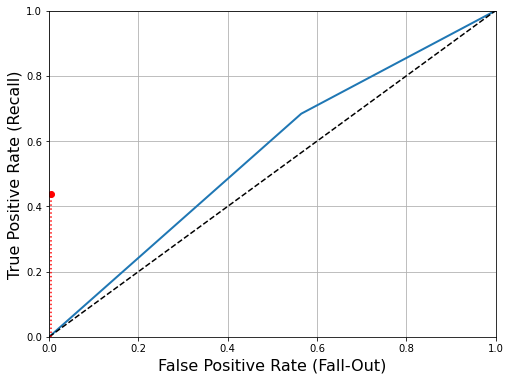

In [94]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [95]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.559696767903343

For Accounts

In [96]:
# Generate summed probabilities at the account level 
def predict_account(model, df_mod, df_bert, df_full):
    predictions = model.predict(df_mod)[:,1]
    df = pd.DataFrame(predictions, columns = ['pred'])
    df_2 = pd.merge(df_bert.reset_index()['user.id'], df, left_index=True, right_index=True)
    df_fm = df_full[['user.screen_name','user.id', 'suspended']].drop_duplicates(subset=['user.screen_name','user.id'])
    df_3 = pd.merge(df_fm, df_2, left_on='user.id', right_on='user.id')
    df_4 = df_3[['user.screen_name', 'suspended','pred']].groupby('user.screen_name').agg(['sum', 'mean'])
    df_4.drop(('suspended', 'sum'), axis = 1, inplace = True)
    df_4.columns = df_4.columns = [' '.join(col).strip() for col in df_4.columns.values]
    df_4.reset_index(level=0, inplace=True)
    df_4.columns = ["user.screen_name","suspended_label", "total_pre_prob","mean_pred_prob"]
    df_4['pred_class'] = np.where(df_4['mean_pred_prob'] > 0.25, 1,0) # Use lighter threshold as not all tweets get an account suspended. 
    df_4 = df_4.sort_values(by=['total_pre_prob'], ascending=False)

    return df_4

In [97]:
# Generate summed probabilities at the account level 
def predict_tweet_text(model, df_mod, df_bert, df_full):
    predictions = model.predict(df_mod)[:,1]
    df = pd.DataFrame(predictions, columns = ['pred'])
    df_2 = pd.merge(df_bert.reset_index()['id'], df, left_index=True, right_index=True)
    df_fm = df_full[['id', 'text','user.screen_name','user.id', 'suspended']].drop_duplicates(subset=['user.screen_name','user.id'])
    df_fm['id'] = df_fm['id'].apply(lambda x: x.replace("'", ''))
    df_fm['id'] = df_fm['id'].astype('float')
    df_fm['id'] = df_fm['id'].astype('str')
    df_fm['id'] = df_fm['id'].apply(lambda x: "'" + x + "'")
    df_2['id'] = df_2['id'].astype('str')
    df_2['id'] = df_2['id'].apply(lambda x: "'" + x + "'")
    df_3 = pd.merge(df_fm, df_2, left_on='id', right_on='id')
    df_3.columns = ["id", "text", "user.screen_name", "user.id", "suspended_label", "pred"]
    df_3 = df_3.sort_values(by=['pred'], ascending=False)

    return df_3

In [98]:
test_preds_tweets = predict_tweet_text(Acc_model, test_data_acc, bert_embeddings_df_test, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
134,'1.2796157737789276e+18',@moerbenqingkong 下次不知道该拍谁了,yAx0wqMUGj7d1uT,1.279606e+18,0,1.0
423,'1.2851525779071222e+18',@Ankitkurmi20 @lareina72611001 @RajatBH7001902...,KingzenJ,1.284701e+18,0,1.0
280,'1.2872158153814958e+18',@wangdan1989 第一，首先是汉人内部的分裂，这种分裂由于国力总体上仍然比较差，一定...,wishworld_peace,1.282180e+18,0,1.0
365,'1.2842616969119785e+18',@EnUin1988 觉得彻骨寒冷 从头到脚,WinnietheKuN,1.283429e+18,0,1.0
64,'1.2819469321689334e+18',#foodie #foodpanda #food #FoodBenders #foodwas...,FoodLov39645299,1.278767e+18,0,1.0


In [99]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/down_test_interp/test_tweets_preds_acc.csv', index=False, encoding = "utf_8_sig")

In [100]:
test_account_preds_acc = predict_account(Acc_model, test_data_acc, bert_embeddings_df_test, df_test)

In [101]:
test_account_preds_acc.to_csv(results_bucket + 'account_level_results/down_test_interp/test_account_preds_acc.csv', index=False, encoding = "utf_8_sig")

In [102]:
#report = classification_report(np.array(test_labels), predictions)
report_te_acc = classification_report(np.array(test_account_preds_acc['suspended_label']), np.array(test_account_preds_acc['pred_class']))
print(report_te_acc)

              precision    recall  f1-score   support

           0       0.94      0.46      0.62       460
           1       0.09      0.66      0.16        38

    accuracy                           0.48       498
   macro avg       0.52      0.56      0.39       498
weighted avg       0.88      0.48      0.58       498



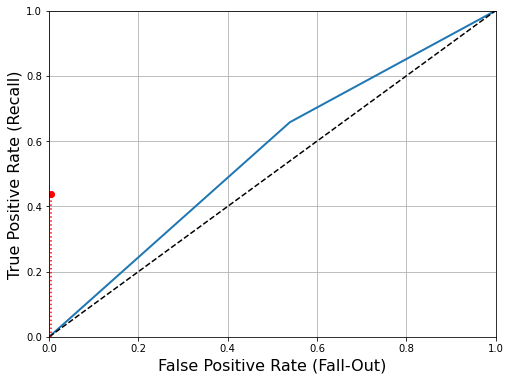

In [103]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_acc['suspended_label']), np.array(test_account_preds_acc['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [104]:
roc_auc_score(np.array(test_account_preds_acc['suspended_label']), np.array(test_account_preds_acc['pred_class']))

0.5593821510297483

Tweet Model Results

In [105]:
def accuracy_plot(title_, history_fit):
    plt.plot(history_fit.history['accuracy'])
    plt.plot(history_fit.history['val_accuracy'])
    plt.title(title_)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    return plt

# CREATE A LOSS PLOT AS WELL!!!!!

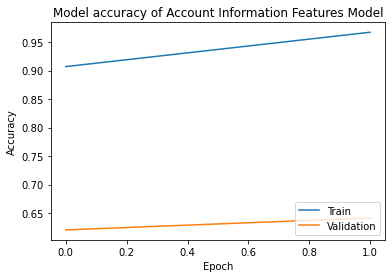

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [3.1829633712768555, 0.46008384227752686]


In [106]:
#train vs validation accuracy plot
plot_acc=accuracy_plot('Model accuracy of Account Information Features Model', history_acc)
print(plot_acc)
#test accuracy and loss 
print("test loss, test accuracy:", Acc_model_results)

In [107]:
def loss_plot(title_, history_fit):
    plt.plot(history_fit.history['loss'])
    plt.plot(history_fit.history['val_loss'])
    plt.title(title_)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.show()
    return plt

# CREATE A LOSS PLOT AS WELL!!!!!

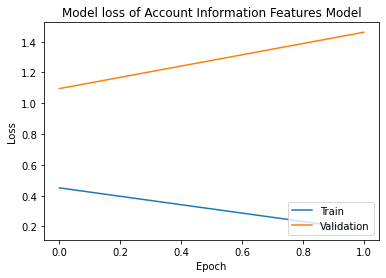

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [3.1829633712768555, 0.46008384227752686]


In [108]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Account Information Features Model', history_acc)
print(plot_loss)
#test accuracy and loss
print("test loss, test accuracy:", Acc_model_results)

#### Combined Model

Multilingual

In [109]:
#make sure numpy array
train_data = np.array(combined_features_train).astype(np.float32)
valid_data = np.array(combined_features_valid).astype(np.float32)
test_data = np.array(combined_features_test).astype(np.float32)

train_labels = labels_train
valid_labels = labels_valid
test_labels = labels_test

In [110]:
#gets shape of the data for the model
input_shape_combined=train_data[0].shape
input_shape_combined

(793,)

In [111]:
train_data[0].shape

(793,)

In [112]:
#set seed
random_seeds(1234)

In [113]:
#test model_flow
Combined_model = model_flow("Combined",num_of_labels, input_shape_combined)

In [114]:
#model summary
Combined_model.summary()


Model: "Combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 793)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50816     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 34 

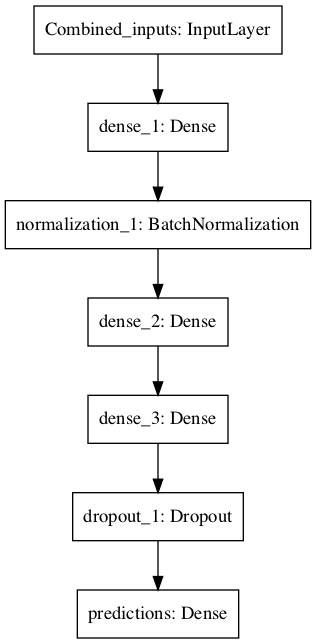

In [115]:
#model diagram
tf.keras.utils.plot_model(Combined_model)

In [116]:
#Compile  model
Combined_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [117]:
#Fitting on training and validation data
print("Fit model on training data")
history_combined = Combined_model.fit(train_data, train_labels, epochs=2, batch_size=15,
                                      validation_data=(valid_data, valid_labels), class_weight = class_weights)

Fit model on training data
Epoch 1/2
1056/1056 [==============================] - 3s 2ms/step - loss: 0.7194 - accuracy: 0.8442 - val_loss: 0.8697 - val_accuracy: 0.6456
Epoch 2/2
1056/1056 [==============================] - 2s 2ms/step - loss: 0.4606 - accuracy: 0.9011 - val_loss: 0.8633 - val_accuracy: 0.6256


In [118]:
# Evaluate the model on the test data
print("Evaluate on test data")
model_results_comb = Combined_model.evaluate(test_data, test_labels, batch_size=10)

Evaluate on test data
2052/2052 [==============================] - 2s 988us/step - loss: 1.7030 - accuracy: 0.5587


#### Save Model 

In [119]:
from tensorflow.keras.layers import LeakyReLU
Combined_model.save('data/s3_data/model_output/down_test_interp_Combined_model.h5')  # creates a HDF5 file 'my_model.h5'

#### Load Model 

In [120]:
from tensorflow.keras.models import load_model

Combined_model = load_model('data/s3_data/model_output/down_test_interp_Combined_model.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Predictions

Tweets

In [121]:
#test predict_test
metrics_report_comb=predict_test(Combined_model,test_data,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_comb)

              precision    recall  f1-score   support

           0       0.92      0.56      0.70     18480
           1       0.12      0.53      0.19      2038

    accuracy                           0.56     20518
   macro avg       0.52      0.55      0.44     20518
weighted avg       0.84      0.56      0.65     20518



In [122]:
predictions = Combined_model.predict(test_data)

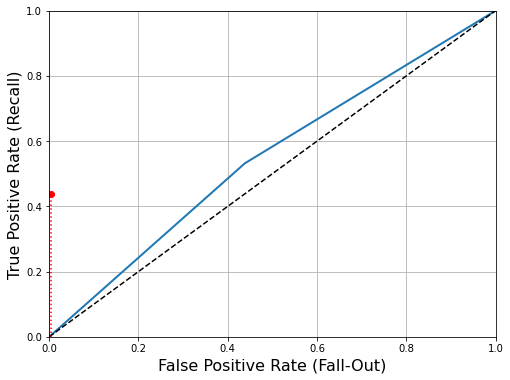

In [123]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [124]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.5467911627136357

In [125]:
test_preds_tweets = predict_tweet_text(Combined_model, test_data, bert_embeddings_df_test, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
257,'1.2845054720039567e+18',@_Siddiqui__ zra translation bhi kr den ye fak...,ABDULLA96649895,1.281695e+18,1,1.000000
64,'1.2819469321689334e+18',#foodie #foodpanda #food #FoodBenders #foodwas...,FoodLov39645299,1.278767e+18,0,1.000000
277,'1.3010897380494418e+18',@Marriyum_A Lol #ShamelessShareem,Azee84757895,1.282021e+18,1,1.000000
74,'1.2796344637611622e+18',@AWWk67D3QPyM6Ji 想抱,xixixix78789521,1.278926e+18,0,1.000000
457,'1.2880794814339236e+18',#ImranKhanPUBGKholo https://t.co/WbtAi0dJgL,RanaHam84452282,1.285869e+18,0,0.999998


In [126]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/down_test_interp/test_tweets_preds_comb.csv', index=False, encoding = "utf_8_sig")

Accounts

In [127]:
test_account_preds_comb = predict_account(Combined_model, test_data, bert_embeddings_df_test, df_test)

In [128]:
test_account_preds_comb.to_csv(results_bucket + 'account_level_results/down_test_interp/test_account_preds_comb.csv', index=False, encoding = "utf_8_sig")

In [129]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb = classification_report(np.array(test_account_preds_comb['suspended_label']), np.array(test_account_preds_comb['pred_class']))
print(report_te_comb)

              precision    recall  f1-score   support

           0       0.97      0.30      0.46       460
           1       0.09      0.87      0.17        38

    accuracy                           0.35       498
   macro avg       0.53      0.59      0.32       498
weighted avg       0.90      0.35      0.44       498



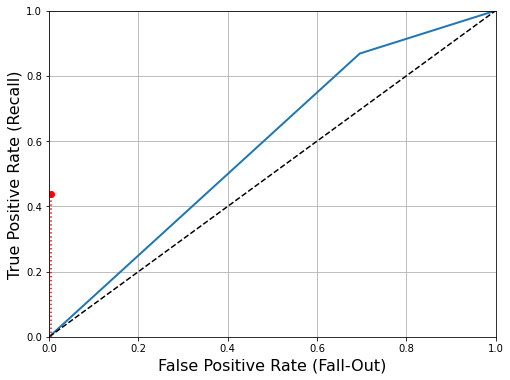

In [130]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb['suspended_label']), np.array(test_account_preds_comb['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [131]:
roc_auc_score(np.array(test_account_preds_comb['suspended_label']), np.array(test_account_preds_comb['pred_class']))

0.5863844393592678

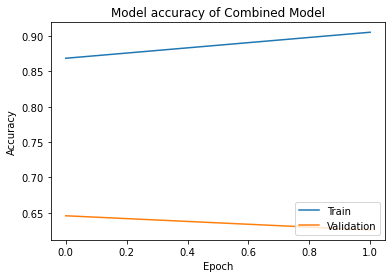

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [1.7030044794082642, 0.5587289333343506]


In [132]:
#train vs validation accuracy plot
plot_combined=accuracy_plot('Model accuracy of Combined Model', history_combined)
print(plot_combined)

print("test loss, test accuracy:", model_results_comb)

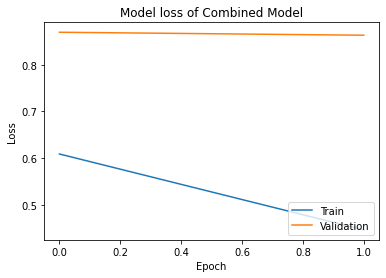

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [1.7030044794082642, 0.5587289333343506]


In [133]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Combined Model', history_combined)
print(plot_loss)
#test accuracy and loss 
print("test loss, test accuracy:", model_results_comb)

#### Labse

In [134]:
#make sure numpy array
train_data_labse = np.array(combined_features_train_labse).astype(np.float32)
valid_data_labse = np.array(combined_features_valid_labse).astype(np.float32)
test_data_labse = np.array(combined_features_test_labse).astype(np.float32)

train_labels_labse = labels_train_labse
valid_labels_labse = labels_valid_labse
test_labels_labse = labels_test_labse

In [135]:
#gets shape of the data for the model
input_shape_combined_labse=valid_data_labse[0].shape
input_shape_combined_labse

(793,)

In [136]:
#set seed
random_seeds(1234)

In [137]:
#test model_flow
Combined_model_labse = model_flow("Combined",num_of_labels, input_shape_combined_labse)

In [138]:
#model summary
Combined_model_labse.summary()

Model: "Combined"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Combined_inputs (InputLayer) [(None, 793)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50816     
_________________________________________________________________
normalization_1 (BatchNormal (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 2)                 34 

In [139]:
#Compile  model
Combined_model_labse.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [140]:
#Fitting on training and validation data
print("Fit model on training data")
history_combined_labse = Combined_model_labse.fit(train_data_labse, train_labels_labse, epochs=2, batch_size=15,
                                      validation_data=(valid_data_labse, valid_labels_labse), class_weight = class_weights_labse)

Fit model on training data
Epoch 1/2
1056/1056 [==============================] - 3s 2ms/step - loss: 0.5715 - accuracy: 0.8809 - val_loss: 1.3389 - val_accuracy: 0.6054
Epoch 2/2
1056/1056 [==============================] - 3s 2ms/step - loss: 0.2881 - accuracy: 0.9409 - val_loss: 1.3672 - val_accuracy: 0.6248


In [141]:
# Evaluate the model on the test data
print("Evaluate on test data")
model_results_comb_labse = Combined_model_labse.evaluate(test_data_labse, test_labels_labse, batch_size=10)

Evaluate on test data
2052/2052 [==============================] - 2s 868us/step - loss: 2.6706 - accuracy: 0.4936


In [142]:
from tensorflow.keras.layers import LeakyReLU
Combined_model_labse.save('data/s3_data/model_output/down_test_interp_Combined_model_labse.h5')  # creates a HDF5 file 'my_model.h5'

In [143]:
from tensorflow.keras.models import load_model

Combined_model_labse = load_model('data/s3_data/model_output/down_test_interp_Combined_model_labse.h5', custom_objects = {'LeakyReLU':LeakyReLU})

In [144]:
#test predict_test
metrics_report_comb_labse=predict_test(Combined_model_labse,test_data_labse,test_labels_labse, fit_test_labse)

# predicted_susp_tweettext
print(metrics_report_comb_labse)

              precision    recall  f1-score   support

           0       0.91      0.49      0.63     18480
           1       0.11      0.55      0.18      2038

    accuracy                           0.49     20518
   macro avg       0.51      0.52      0.41     20518
weighted avg       0.83      0.49      0.59     20518



In [145]:
predictions = Combined_model_labse.predict(test_data_labse)

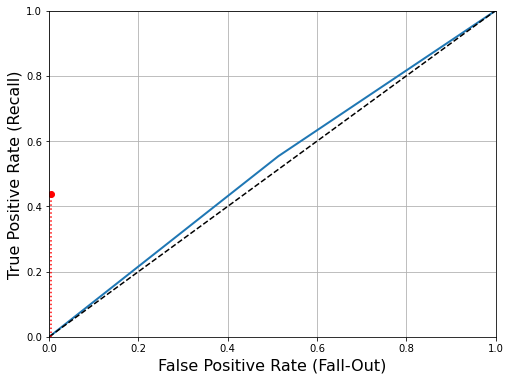

In [146]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [147]:
roc_auc_score(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))

0.5202213410567189

Accounts

In [148]:
test_preds_tweets = predict_tweet_text(Combined_model_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
198,'1.2898924826924196e+18',@junaid_talaat So are you,Aurangtweets,1.280482e+18,0,1.0
277,'1.3010897380494418e+18',@Marriyum_A Lol #ShamelessShareem,Azee84757895,1.282021e+18,1,1.0
457,'1.2880794814339236e+18',#ImranKhanPUBGKholo https://t.co/WbtAi0dJgL,RanaHam84452282,1.285869e+18,0,1.0
449,'1.2880096353796096e+18',@Vikashk62800388 @CGTNOfficial 恶心🙂,shanheyonggu2,1.285622e+18,0,1.0
74,'1.2796344637611622e+18',@AWWk67D3QPyM6Ji 想抱,xixixix78789521,1.278926e+18,0,1.0


In [149]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/down_test_interp/test_tweets_preds_comb_labse.csv', index=False, encoding = "utf_8_sig")

Test

In [150]:
test_account_preds_comb_labse = predict_account(Combined_model_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)

In [151]:
test_account_preds_comb_labse.to_csv(results_bucket + 'account_level_results/down_test_interp/test_account_preds_comb_labse.csv', index=False, encoding = "utf_8_sig")

In [152]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb_labse = classification_report(np.array(test_account_preds_comb_labse['suspended_label']), np.array(test_account_preds_comb_labse['pred_class']))
print(report_te_comb_labse)

              precision    recall  f1-score   support

           0       0.96      0.42      0.58       460
           1       0.10      0.76      0.17        38

    accuracy                           0.44       498
   macro avg       0.53      0.59      0.38       498
weighted avg       0.89      0.44      0.55       498



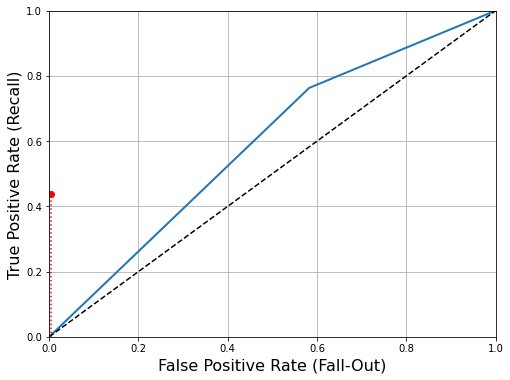

In [153]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb_labse['suspended_label']), np.array(test_account_preds_comb_labse['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [154]:
roc_auc_score(np.array(test_account_preds_comb_labse['suspended_label']), np.array(test_account_preds_comb_labse['pred_class']))

0.5902745995423341

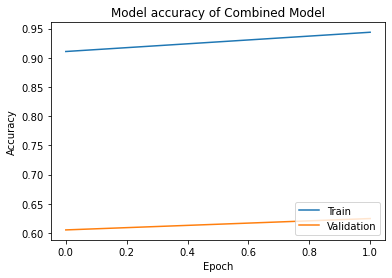

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [2.6705548763275146, 0.493566632270813]


In [155]:
#train vs validation accuracy plot
plot_combined=accuracy_plot('Model accuracy of Combined Model', history_combined_labse)
print(plot_combined)
#test accuracy
print("test loss, test accuracy:", model_results_comb_labse)

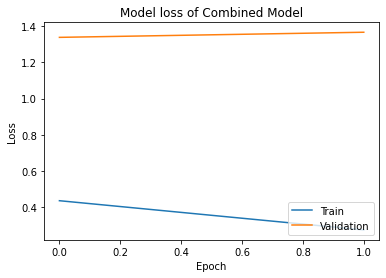

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [2.6705548763275146, 0.493566632270813]


In [156]:
#train vs validation loss plot
plot_loss=loss_plot('Model loss of Combined Model', history_combined_labse)
print(plot_loss)
#test loss and accuracy
print("test loss, test accuracy:", model_results_comb_labse)

### 3. Fine Tuning Models

In [157]:
#Callbacks
callback1=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)

In [158]:
#clears training output
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

#### Account Only Model 

In [159]:
#input shape for account features
input_shape_acc=train_data_acc[0].shape
input_shape_acc

(25,)

In [160]:
def tuner_builder1(hp):
    inputs = keras.Input(shape=input_shape_acc, name="Tuned_Account_Info_Inputs")
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Account_Info_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy'])
    return model

In [161]:
#tuner settings 
Acc_info_tuner = kt.Hyperband(
    tuner_builder1,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_acc_info3',
    project_name = 'Parameters_trials_acc_info96969692') # Need to be unique with each run!

In [162]:
#run through tuner
Acc_info_tuner.search(train_data_acc, train_labels,validation_data=(valid_data_acc, valid_labels),callbacks=[callback1,ClearTrainingOutput()])


Trial 90 Complete [00h 00m 06s]
val_accuracy: 0.6815233826637268

Best val_accuracy So Far: 0.8413136601448059
Total elapsed time: 00h 07m 10s
INFO:tensorflow:Oracle triggered exit


In [163]:
#gets best parameters
best_hyper_Acc_info = Acc_info_tuner.get_best_hyperparameters(1)[0]
best_hyper_Acc_info
    

In [164]:
print('Best Parameters for 1st Dense layer is', best_hyper_Acc_info.get('units'))

Best Parameters for 1st Dense layer is 130


In [165]:
print('Best Parameters for 2nd Dense layer is', best_hyper_Acc_info.get('units1'))

Best Parameters for 2nd Dense layer is 100


In [166]:
print('Best Parameters for 3rd Dense layer is', best_hyper_Acc_info.get('units2'))

Best Parameters for 3rd Dense layer is 40


In [167]:
print('Best Parameters for Dropout layer is', best_hyper_Acc_info.get('dropout'))

Best Parameters for Dropout layer is 0.0


In [168]:
print('Best learning rate for the ADAM is', best_hyper_Acc_info.get('learning_rate'))

Best learning rate for the ADAM is 0.0004747431780433045


In [169]:
#applies to tuning to model
Acc_info_model_tuned= Acc_info_tuner.hypermodel.build(best_hyper_Acc_info)

In [170]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned Account Information model")
history_acc_info_tuned = Acc_info_model_tuned.fit(train_data_acc, train_labels, epochs=2, batch_size=15,
                   validation_data=(valid_data_acc, valid_labels), class_weight = class_weights)

Fit model on training data with tuned Account Information model
Epoch 1/2
1056/1056 [==============================] - 2s 2ms/step - loss: 0.6178 - accuracy: 0.8631 - val_loss: 0.5894 - val_accuracy: 0.7927
Epoch 2/2
1056/1056 [==============================] - 2s 2ms/step - loss: 0.1412 - accuracy: 0.9736 - val_loss: 0.6954 - val_accuracy: 0.7907


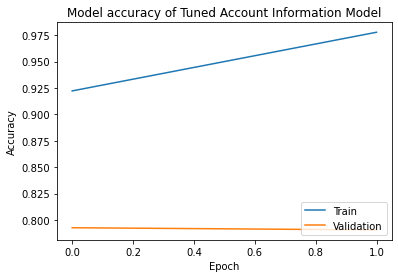

In [171]:
plot_acc_info_tuned=accuracy_plot('Model accuracy of Tuned Account Information Model', history_acc_info_tuned)

In [172]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned Account Information model on test data")
acc_info_tuned_results = Acc_info_model_tuned.evaluate(test_data_acc, test_labels, batch_size=10)

Evaluate tuned Account Information model on test data
2052/2052 [==============================] - 1s 603us/step - loss: 3.2391 - accuracy: 0.5078


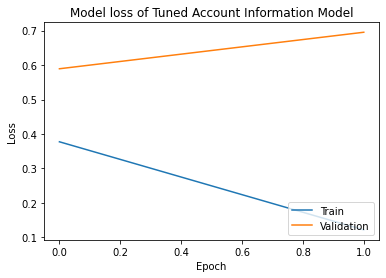

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [3.2390642166137695, 0.5077980160713196]


In [173]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Tuned Account Information Model', history_acc_info_tuned)
print(plot_loss)
#valid accuracy and loss 
print("test loss, test accuracy:", acc_info_tuned_results)

#### Save Model 

In [174]:
from tensorflow.keras.layers import LeakyReLU
Acc_info_model_tuned.save('data/s3_data/model_output/down_test_interp_Acc_info_model_tuned.h5')  # creates a HDF5 file 'my_model.h5'

#### Load Model 

In [175]:
from tensorflow.keras.models import load_model
Acc_info_model_tuned = load_model('data/s3_data/model_output/down_test_interp_Acc_info_model_tuned.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Predict 

Tweets

In [176]:
#test predict_test
metrics_report_acc_tuned=predict_test(Acc_info_model_tuned,test_data_acc,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_acc_tuned)

              precision    recall  f1-score   support

           0       0.95      0.48      0.64     18480
           1       0.14      0.75      0.23      2038

    accuracy                           0.51     20518
   macro avg       0.54      0.62      0.44     20518
weighted avg       0.87      0.51      0.60     20518



In [177]:
predictions = Acc_info_model_tuned.predict(test_data_acc)

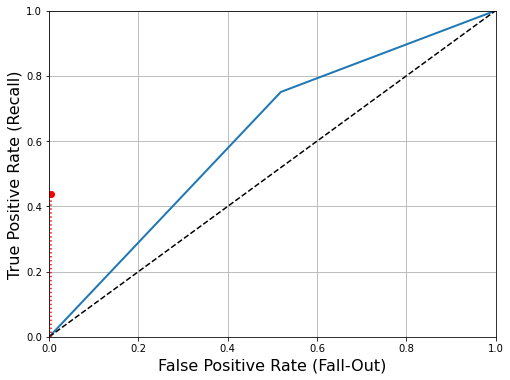

In [178]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [179]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.6158712546040809

In [180]:
test_preds_tweets = predict_tweet_text(Acc_info_model_tuned, test_data_acc, bert_embeddings_df_test, df_test)
test_preds_tweets.head()


,id,text,user.screen_name,user.id,suspended_label,pred
277,'1.3010897380494418e+18',@Marriyum_A Lol #ShamelessShareem,Azee84757895,1.282021e+18,1,1.0
449,'1.2880096353796096e+18',@Vikashk62800388 @CGTNOfficial 恶心🙂,shanheyonggu2,1.285622e+18,0,1.0
198,'1.2898924826924196e+18',@junaid_talaat So are you,Aurangtweets,1.280482e+18,0,1.0
49,'1.3020707350960497e+18',@AliceWh57329522 @LosSantoPD @MrGoodCitizen @K...,R_F_fangfang,1.278635e+18,0,1.0
288,'1.2868546382228726e+18',@LinyingLee @janliuhair @SpokespersonCHN https...,TsetenPhurbu,1.282303e+18,1,1.0


In [181]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/down_test_interp/test_tweets_preds_acc_tuned.csv', index=False, encoding = "utf_8_sig")

Accounts

In [182]:
test_account_preds_acc_tuned = predict_account(Acc_info_model_tuned, test_data_acc, bert_embeddings_df_test, df_test)
test_account_preds_acc_tuned

,user.screen_name,suspended_label,total_pre_prob,mean_pred_prob,pred_class
476,wishworld_peace,0,9.110000e+02,1.000000e+00,1
447,sharelingnan,0,7.839607e+02,9.999499e-01,1
148,John97242303,0,6.981263e+02,6.891671e-01,1
232,R_F_fangfang,0,6.610000e+02,1.000000e+00,1
370,fWsArCRQJMn0koq,0,6.082756e+02,8.628023e-01,1
...,...,...,...,...,...
284,Tommy06774615,0,1.318448e-06,2.060074e-08,0
335,ahmad_taifoor,0,1.215989e-06,6.079943e-07,0
202,Muhamma82599808,0,1.177496e-06,5.887480e-07,0
454,sunsiya4,0,7.053834e-07,7.837593e-08,0


In [183]:
test_account_preds_acc_tuned.to_csv(results_bucket + 'account_level_results/down_test_interp/test_account_preds_acc_tuned.csv', index=False, encoding = "utf_8_sig")

In [184]:
#report = classification_report(np.array(test_labels), predictions)
report_te_acc_tuned_tuned = classification_report(np.array(test_account_preds_acc_tuned['suspended_label']), np.array(test_account_preds_acc_tuned['pred_class']))
print(report_te_acc_tuned_tuned)

              precision    recall  f1-score   support

           0       0.94      0.45      0.61       460
           1       0.09      0.63      0.15        38

    accuracy                           0.47       498
   macro avg       0.51      0.54      0.38       498
weighted avg       0.87      0.47      0.58       498



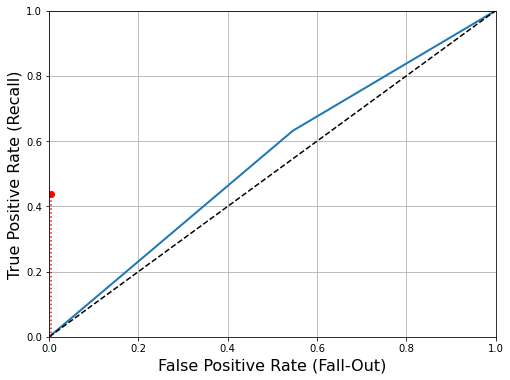

In [185]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_acc_tuned['suspended_label']), np.array(test_account_preds_acc_tuned['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [186]:
roc_auc_score(np.array(test_account_preds_acc_tuned['suspended_label']), np.array(test_account_preds_acc_tuned['pred_class']))

0.5429633867276888

#### Combined Model

Multilingual BERT

In [187]:
#gets shape of the data for the model
input_shape_combined=train_data[0].shape
input_shape_combined

(793,)

In [188]:
#Function to tune to the model
def tuner_builder(hp):
    inputs = keras.Input(shape=input_shape_combined, name="Tuned_Combined_Inputs") # They had 3333 (w CV) -> I hard coded my model shape. 
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x) # I get error now, but with full data there will be 2
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Combined_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [190]:
#tuner settings 
Combined_tuner = kt.Hyperband(
    tuner_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_combined3',
    project_name = 'Parameters_trials_combined_3222285') # Need to be unique with each run!

In [191]:
#run through tuner
Combined_tuner.search(train_data, train_labels,validation_data=(valid_data, valid_labels),
             callbacks=[callback1,ClearTrainingOutput()])

Trial 90 Complete [00h 00m 06s]
val_accuracy: 0.6231544017791748

Best val_accuracy So Far: 0.7011176943778992
Total elapsed time: 00h 08m 31s
INFO:tensorflow:Oracle triggered exit


In [192]:
#gets best parameters
best_hyper_combined = Combined_tuner.get_best_hyperparameters(1)[0]
best_hyper_combined

In [193]:
print('Best Parameters for 1st Dense layer is', best_hyper_combined.get('units'))

Best Parameters for 1st Dense layer is 130


In [194]:
print('Best Parameters for 2nd Dense layer is', best_hyper_combined.get('units1'))

Best Parameters for 2nd Dense layer is 150


In [195]:
print('Best Parameters for 3rd Dense layer is', best_hyper_combined.get('units2'))

Best Parameters for 3rd Dense layer is 40


In [196]:
print('Best Parameters for Dropout layer is', best_hyper_combined.get('dropout'))

Best Parameters for Dropout layer is 0.4


In [197]:
print('Best learning rate for the ADAM is', best_hyper_combined.get('learning_rate'))

Best learning rate for the ADAM is 0.002189960007530227


In [198]:
#applies to tuning to model
Combined_model_tuned= Combined_tuner.hypermodel.build(best_hyper_combined)

In [199]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned model")
history_combined_tuned = Combined_model_tuned.fit(train_data, train_labels, epochs=2, batch_size=15,
                   validation_data=(valid_data, valid_labels), class_weight = class_weights)

Fit model on training data with tuned model
Epoch 1/2
1056/1056 [==============================] - 3s 3ms/step - loss: 0.7111 - accuracy: 0.8439 - val_loss: 0.9980 - val_accuracy: 0.6092
Epoch 2/2
1056/1056 [==============================] - 3s 3ms/step - loss: 0.4697 - accuracy: 0.9003 - val_loss: 1.1553 - val_accuracy: 0.6211


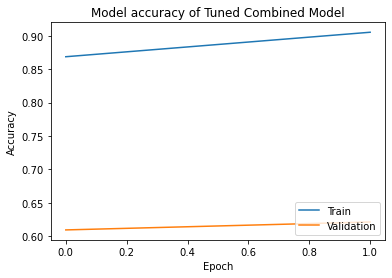

In [200]:
plot_combined_tuned=accuracy_plot('Model accuracy of Tuned Combined Model', history_combined_tuned)

In [201]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned model on test data")
Combined_model_tuned_results = Combined_model_tuned.evaluate(test_data, test_labels, batch_size=10)

Evaluate tuned model on test data
2052/2052 [==============================] - 2s 1ms/step - loss: 2.0433 - accuracy: 0.5015


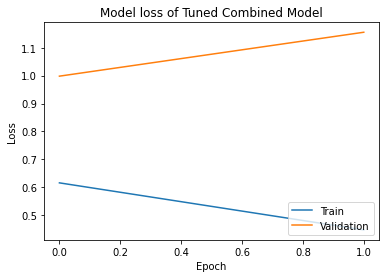

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [2.043297052383423, 0.5014621019363403]


In [202]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model loss of Tuned Combined Model', history_combined_tuned)
print(plot_loss)
#valid accuracy and loss 
print("test loss, test accuracy:", Combined_model_tuned_results)

#### Save Model 

In [203]:
from tensorflow.keras.layers import LeakyReLU
Combined_model_tuned.save('data/s3_data/model_output/down_test_interp_Combined_model_tuned.h5')  # creates a HDF5 file 'my_model.h5'

#### Import Model 

In [204]:
from tensorflow.keras.models import load_model
Combined_model_tuned = load_model('data/s3_data/model_output/down_test_interp_Combined_model_tuned.h5', custom_objects = {'LeakyReLU':LeakyReLU})

#### Predict

Tweets

In [205]:
#test predict_test
metrics_report_comb_tuned=predict_test(Combined_model_tuned,test_data,test_labels, fit_test)

# predicted_susp_tweettext
print(metrics_report_comb_tuned)

              precision    recall  f1-score   support

           0       0.91      0.50      0.64     18480
           1       0.11      0.54      0.18      2038

    accuracy                           0.50     20518
   macro avg       0.51      0.52      0.41     20518
weighted avg       0.83      0.50      0.60     20518



In [206]:
predictions = Combined_model_tuned.predict(test_data)

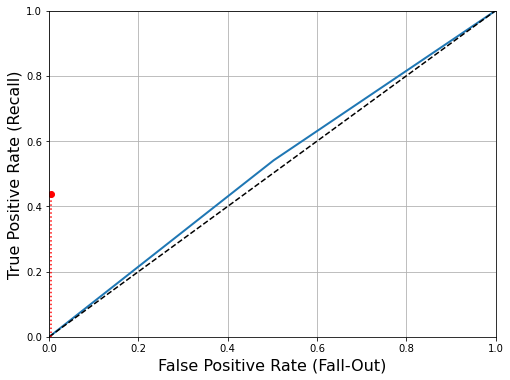

In [207]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [208]:
roc_auc_score(np.argmax(test_labels, axis=1), np.argmax(predictions, axis=1))

0.5191474006856736

In [209]:
test_preds_tweets = predict_tweet_text(Combined_model_tuned, test_data, bert_embeddings_df_test, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
433,'1.2877905109421957e+18',@zhang_heqing 关注了,FhSYkK3LVq2bya9,1.285047e+18,1,1.0
257,'1.2845054720039567e+18',@_Siddiqui__ zra translation bhi kr den ye fak...,ABDULLA96649895,1.281695e+18,1,1.0
64,'1.2819469321689334e+18',#foodie #foodpanda #food #FoodBenders #foodwas...,FoodLov39645299,1.278767e+18,0,1.0
277,'1.3010897380494418e+18',@Marriyum_A Lol #ShamelessShareem,Azee84757895,1.282021e+18,1,1.0
74,'1.2796344637611622e+18',@AWWk67D3QPyM6Ji 想抱,xixixix78789521,1.278926e+18,0,1.0


In [210]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/down_test_interp/test_tweets_preds_comb_tuned.csv', index=False, encoding = "utf_8_sig")

Accounts

In [211]:
test_account_preds_comb_tuned = predict_account(Combined_model_tuned, test_data, bert_embeddings_df_test, df_test)

In [212]:
test_account_preds_comb_tuned.to_csv(results_bucket + 'account_level_results/down_test_interp/test_account_preds_comb_tuned.csv', index=False, encoding = "utf_8_sig")

In [213]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb = classification_report(np.array(test_account_preds_comb_tuned['suspended_label']), np.array(test_account_preds_comb_tuned['pred_class']))
print(report_te_comb)

              precision    recall  f1-score   support

           0       0.96      0.23      0.37       460
           1       0.09      0.87      0.16        38

    accuracy                           0.28       498
   macro avg       0.52      0.55      0.26       498
weighted avg       0.89      0.28      0.36       498



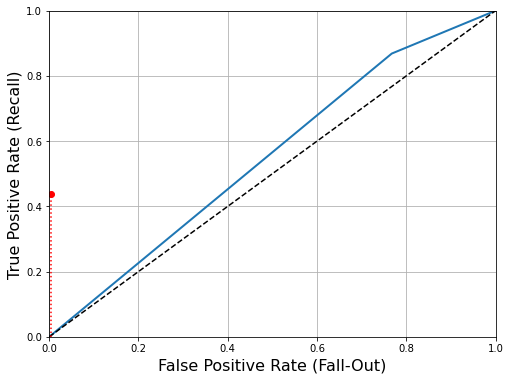

In [214]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb_tuned['suspended_label']), np.array(test_account_preds_comb_tuned['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [215]:
roc_auc_score(np.array(test_account_preds_comb_tuned['suspended_label']), np.array(test_account_preds_comb_tuned['pred_class']))

0.5505148741418764

Combined Model with LAbse

In [216]:
#gets shape of the data for the model
input_shape_combined_labse=train_data_labse[0].shape
input_shape_combined_labse

(793,)

In [217]:
#Function to tune to the model
def tuner_builder(hp):
    inputs = keras.Input(shape=input_shape_combined_labse, name="Tuned_Combined_Inputs") # They had 3333 (w CV) -> I hard coded my model shape. 
    x = layers.Dense(hp.Int('units', 50, 200, step = 20), activation="relu", name="dense_1")(inputs)
    x = layers.BatchNormalization(name="normalization_1")(x)
    x = layers.Dense(hp.Int('units1', 100, 200, step = 50), activation="relu",name="dense_2")(x)
    x = layers.Dense(hp.Int('units2', 20, 100, step = 20), activation=tf.keras.layers.LeakyReLU(alpha=0.2), name="dense_3")(x)
    x = layers.Dropout(hp.Float('dropout',0.0,0.50, step=0.10, default=0.10))(x)
    outputs = layers.Dense(2, activation="softmax",name="predictions")(x) # I get error now, but with full data there will be 2
    model = keras.Model(inputs=inputs, outputs=outputs, name="Tuned_Combined_Model")
    #Compile  model
    model.compile(optimizer=tf.keras.optimizers.Adam(
        hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

In [218]:
#tuner settings 
Combined_tuner = kt.Hyperband(
    tuner_builder,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory = 'Trial_run_combined2',
    project_name = 'Parameters_trials_combined_labse_577999') # Need to be unique with each run!

In [219]:
#run through tuner
Combined_tuner.search(train_data_labse, train_labels_labse,validation_data=(valid_data_labse, valid_labels_labse),
             callbacks=[callback1,ClearTrainingOutput()])

Trial 90 Complete [00h 00m 06s]
val_accuracy: 0.6219125390052795

Best val_accuracy So Far: 0.6961501240730286
Total elapsed time: 00h 08m 26s
INFO:tensorflow:Oracle triggered exit


In [220]:
#gets best parameters
best_hyper_combined_labse = Combined_tuner.get_best_hyperparameters(1)[0]
best_hyper_combined_labse

In [221]:
print('Best Parameters for 1st Dense layer is', best_hyper_combined_labse.get('units'))

Best Parameters for 1st Dense layer is 170


In [222]:
print('Best Parameters for 2nd Dense layer is', best_hyper_combined_labse.get('units1'))

Best Parameters for 2nd Dense layer is 150


In [223]:
print('Best Parameters for 3rd Dense layer is', best_hyper_combined_labse.get('units2'))

Best Parameters for 3rd Dense layer is 20


In [224]:
print('Best Parameters for Dropout layer is', best_hyper_combined_labse.get('dropout'))

Best Parameters for Dropout layer is 0.1


In [225]:
print('Best learning rate for the ADAM is', best_hyper_combined_labse.get('learning_rate'))

Best learning rate for the ADAM is 0.0004911291388452933


In [226]:
#applies to tuning to model
Combined_model_tuned_labse= Combined_tuner.hypermodel.build(best_hyper_combined_labse)

In [227]:
#trials using newly tuned model
#Fitting on training and validation data based on selected tuning parameters
print("Fit model on training data with tuned model")
history_combined_tuned_labse = Combined_model_tuned_labse.fit(train_data_labse, train_labels_labse, epochs=2, batch_size=15,
                   validation_data=(valid_data_labse, valid_labels_labse), class_weight = class_weights_labse)

Fit model on training data with tuned model
Epoch 1/2
1056/1056 [==============================] - 3s 2ms/step - loss: 0.4959 - accuracy: 0.8916 - val_loss: 0.9385 - val_accuracy: 0.6746
Epoch 2/2
1056/1056 [==============================] - 3s 2ms/step - loss: 0.1871 - accuracy: 0.9631 - val_loss: 1.2842 - val_accuracy: 0.6262


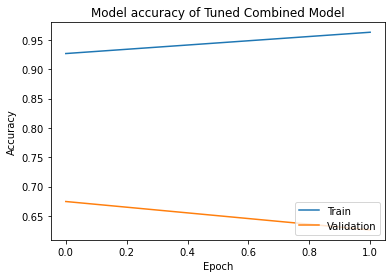

In [228]:
plot_combined_tuned_labse=accuracy_plot('Model accuracy of Tuned Combined Model', history_combined_tuned_labse)

In [229]:
# Evaluate the tuned model on the test data 
print("Evaluate tuned model on test data")
Combined_model_tuned_results_labse = Combined_model_tuned_labse.evaluate(test_data_labse, test_labels_labse, batch_size=10)

Evaluate tuned model on test data
2052/2052 [==============================] - 2s 1ms/step - loss: 2.8612 - accuracy: 0.4903


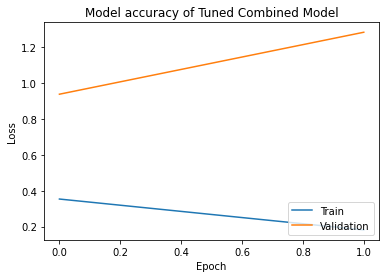

<module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>
test loss, test accuracy: [2.8611974716186523, 0.4903499484062195]


In [230]:
#train vs validation accuracy plot
plot_loss=loss_plot('Model accuracy of Tuned Combined Model', history_combined_tuned_labse)
print(plot_loss)
#valid accuracy and loss 
print("test loss, test accuracy:", Combined_model_tuned_results_labse)

In [231]:
from tensorflow.keras.layers import LeakyReLU
Combined_model_tuned_labse.save('data/s3_data/model_output/down_test_interp_Combined_model_tuned_labse.h5')  # creates a HDF5 file 'my_model.h5'

In [232]:
from tensorflow.keras.models import load_model
Combined_model_tuned_labse= load_model('data/s3_data/model_output/down_test_interp_Combined_model_tuned_labse.h5', custom_objects = {'LeakyReLU':LeakyReLU})

In [233]:
#test predict_test
metrics_report_comb_tuned_labse=predict_test(Combined_model_tuned_labse,test_data_labse,test_labels_labse, fit_test_labse)

# predicted_susp_tweettext
print(metrics_report_comb_tuned_labse)

              precision    recall  f1-score   support

           0       0.90      0.49      0.63     18480
           1       0.10      0.53      0.17      2038

    accuracy                           0.49     20518
   macro avg       0.50      0.51      0.40     20518
weighted avg       0.82      0.49      0.59     20518



In [234]:
predictions = Combined_model_tuned_labse.predict(test_data_labse)

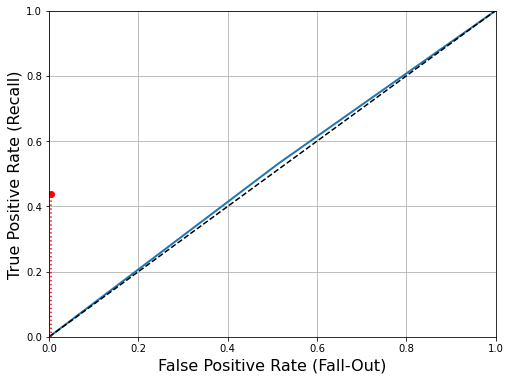

In [235]:
fpr, tpr, thresholds = roc_curve(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [236]:
roc_auc_score(np.argmax(test_labels_labse, axis=1), np.argmax(predictions, axis=1))

0.5088312060036789

In [237]:
test_preds_tweets = predict_tweet_text(Combined_model_tuned_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)
test_preds_tweets.head()

,id,text,user.screen_name,user.id,suspended_label,pred
449,'1.2880096353796096e+18',@Vikashk62800388 @CGTNOfficial 恶心🙂,shanheyonggu2,1.285622e+18,0,1.0
277,'1.3010897380494418e+18',@Marriyum_A Lol #ShamelessShareem,Azee84757895,1.282021e+18,1,1.0
134,'1.2796157737789276e+18',@moerbenqingkong 下次不知道该拍谁了,yAx0wqMUGj7d1uT,1.279606e+18,0,1.0
198,'1.2898924826924196e+18',@junaid_talaat So are you,Aurangtweets,1.280482e+18,0,1.0
117,'1.2799627753772032e+18',@ZGWWS @IzMayckf 欢迎回归，不过改国号了，现在叫中国人民共和国。,YChengkai,1.279419e+18,0,1.0


In [238]:
test_preds_tweets.to_csv(results_bucket + 'account_level_results/down_test_interp/test_tweets_preds_comb_tuned_labse.csv', index=False, encoding = "utf_8_sig")

Test

In [239]:
test_account_preds_comb_tuned_labse = predict_account(Combined_model_tuned_labse, test_data_labse, bert_embeddings_df_test_labse, df_test)

In [240]:
test_account_preds_comb_tuned_labse.to_csv(results_bucket + 'account_level_results/down_test_interp/test_account_preds_comb_tuned_labse.csv', index=False, encoding = "utf_8_sig")

In [241]:
#report = classification_report(np.array(test_labels), predictions)
report_te_comb_labse = classification_report(np.array(test_account_preds_comb_tuned_labse['suspended_label']), np.array(test_account_preds_comb_tuned_labse['pred_class']))
print(report_te_comb_labse)

              precision    recall  f1-score   support

           0       0.96      0.44      0.61       460
           1       0.10      0.76      0.18        38

    accuracy                           0.47       498
   macro avg       0.53      0.60      0.39       498
weighted avg       0.89      0.47      0.57       498



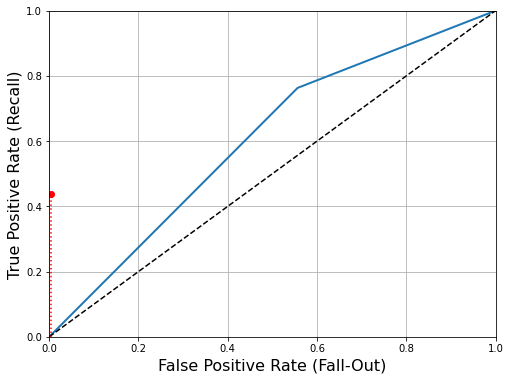

In [242]:
fpr, tpr, thresholds = roc_curve(np.array(test_account_preds_comb_tuned_labse['suspended_label']), np.array(test_account_preds_comb_tuned_labse['pred_class']))
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [243]:
roc_auc_score(np.array(test_account_preds_comb_tuned_labse['suspended_label']), np.array(test_account_preds_comb_tuned_labse['pred_class']))

0.6033180778032037